In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import matplotlib.pyplot as plt
import ast
import cv2
import seaborn as sns

In [3]:
reef_df = pd.read_csv('/kaggle/input/tensorflow-great-barrier-reef/train.csv')

In [4]:
print(reef_df.head())
print('No. of samples: ', len(reef_df))

   video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []
No. of samples:  23501


In [5]:
missing_annotations = reef_df[reef_df['annotations'] == '[]']
print(missing_annotations.head())
print('No. of missing samples: ', len(missing_annotations))

   video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []
No. of missing samples:  18582


In [6]:
print(f"Percentage of samples with BBox: {(1-len(missing_annotations)/len(reef_df))*100:0.2f}%")

Percentage of samples with BBox: 20.93%


In [7]:
# remove no bbox images
reef_df = reef_df[reef_df['annotations'] != '[]'].reset_index()
reef_df.isna().sum()

index             0
video_id          0
sequence          0
video_frame       0
sequence_frame    0
image_id          0
annotations       0
dtype: int64

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

In [9]:
ROOT_DIR = "/kaggle/input/tensorflow-great-barrier-reef/"

In [10]:
# cast string to list of dictionary
reef_df['annotations'] = reef_df['annotations'].progress_apply(eval)
reef_df['img_path'] = ROOT_DIR + '/train_images/video_' + \
                            reef_df.video_id.astype(str)+'/' + reef_df.video_frame.astype(str)+'.jpg'

  0%|          | 0/4919 [00:00<?, ?it/s]

In [11]:
reef_df.head()

,index,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path
0,16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...
1,17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...
2,18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...
3,19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...
4,20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...


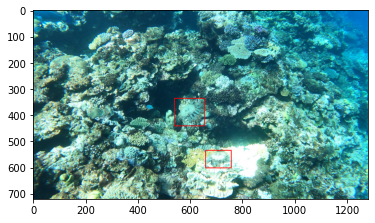

In [12]:
def display(index):
    img_meta = reef_df.iloc[index]
    vid = img_meta['video_id']
    vframe = img_meta['video_frame']
    path = '/kaggle/input/tensorflow-great-barrier-reef/train_images/video_'+f'{vid}'+'/'+f'{vframe}'+'.jpg'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxes = img_meta['annotations']
    for bbox in bboxes:
        x1, x2, y1, y2 = bbox['x'], bbox['x']+bbox['width'], bbox['y'], bbox['y']+bbox['height']
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
    plt.imshow(img)
    plt.show()
    
display(40)

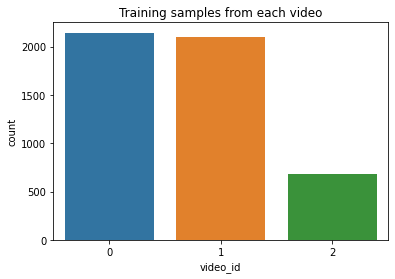

In [13]:
sns.countplot(x='video_id', data=reef_df).set(title='Training samples from each video')
plt.show()

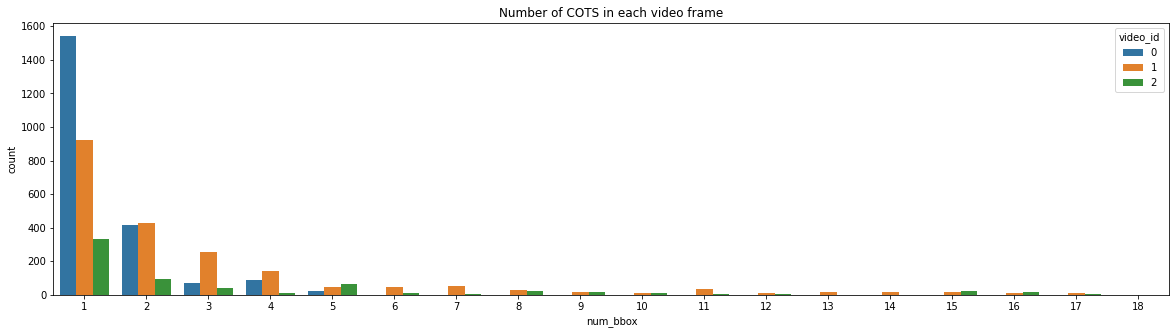

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
reef_df['num_bbox'] = reef_df['annotations'].apply(lambda x: len(x))
sns.countplot(data=reef_df, x="num_bbox", hue='video_id').set(title='Number of COTS in each video frame')
plt.show()

In [15]:
# # Check if all the size of images equal(takes a while so don't rerun it)
# img_sizes = reef_df['img_path'].progress_apply(lambda x: cv2.imread(x).shape)
# print("Does all images have same size?", img_size.all())

In [16]:
image = cv2.imread(reef_df.iloc[16]['img_path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [17]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomCrop(720,720),
])

2022-04-05 18:26:41.895252: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


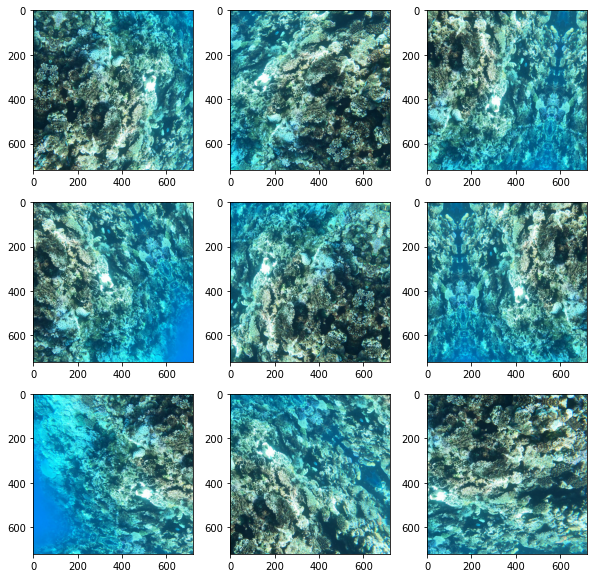

In [18]:
# example images after augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)
plt.savefig('/kaggle/working/aug')

In [19]:
def display_transformed_image(img, index, ax):
    img_meta = reef_df.iloc[index]
    vid = img_meta['video_id']
    vframe = img_meta['video_frame']
    bboxes = img_meta['annotations']
    for bbox in bboxes:
        x1, x2, y1, y2 = bbox['x'], bbox['x']+bbox['width'], bbox['y'], bbox['y']+bbox['height']
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
    ax.imshow(img)

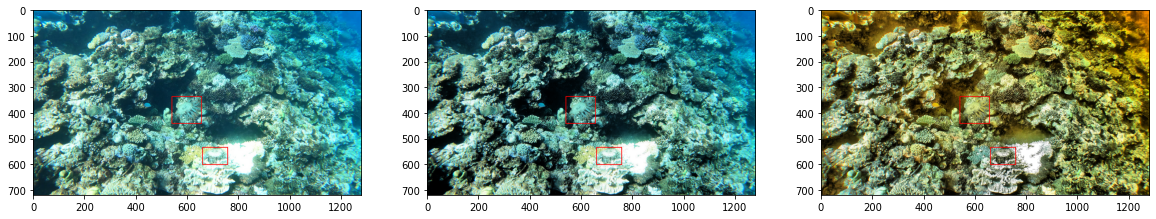

In [20]:
def he_hsv(img_demo):
    img_hsv = cv2.cvtColor(img_demo, cv2.COLOR_RGB2HSV)
    # Histogram equalisation on the V-channel
    img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
    image_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return image_hsv

def clahe_hsv(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
    clahe = cv2.createCLAHE(clipLimit = 100.0, tileGridSize = (10,10))
    v = clahe.apply(v)
    hsv_img = np.dstack((h,s,v))
    rgb = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return rgb

index = 40
image = cv2.imread(reef_df.iloc[index]['img_path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,3,figsize=(20,20))
display_transformed_image(image, index, ax[0])
display_transformed_image(he_hsv(image), index, ax[1])
display_transformed_image(clahe_hsv(image), index, ax[2])
plt.show()

In [21]:
def bbox_to_yolo():
    yolo_annotations = list()
    for index, row in reef_df.iterrows():
        bboxes = row['annotations']
        yolo_bboxes = list()
        for bbox in bboxes:
            x,y = bbox['x']+bbox['width']/2, bbox['y']+bbox['height']/2
            yolo_bboxes.append({'x': x, 'y': y})
        yolo_annotations.append(yolo_bboxes)
    reef_df['yolo_annotations'] = yolo_annotations

bbox_to_yolo()

In [22]:
reef_df.head()

,index,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,num_bbox,yolo_annotations
0,16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...,1,"[{'x': 584.0, 'y': 229.0}]"
1,17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...,1,"[{'x': 583.0, 'y': 229.0}]"
2,18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...,1,"[{'x': 582.0, 'y': 229.0}]"
3,19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...,1,"[{'x': 581.0, 'y': 230.0}]"
4,20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",/kaggle/input/tensorflow-great-barrier-reef//t...,1,"[{'x': 580.0, 'y': 230.0}]"


In [23]:
import numpy as np
from sklearn.model_selection import GroupKFold
groups = reef_df['sequence']
group_kfold = GroupKFold(n_splits=5)
X = reef_df.drop(['annotations'], axis=1)
y = reef_df['annotations']
for train_index, test_index in group_kfold.split(X, y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 4916 4917 4918] TEST: [2330 2331 2332 ... 3427 3428 3429]
TRAIN: [   0    1    2 ... 4916 4917 4918] TEST: [ 285  286  287  288  289  290  291  292  293  294  295  296  297  298
  299  300  301  302  303  304  305  306  307  308  309  310  311  312
  313  314  315  316  317  318  319  320  321  322  323  324  325  326
  327  328  329  330  331  332  333  334  335  336  337  338  339  340
  341  342  343  344  345  346  347  348  349  350  351  352  353  354
  355  356  357  358  359  360  361  362  363  364  365  366  367  368
  369  370  371  372  373  374  375  376  377  378  379  380  381  382
  383  384  385  386  387  388  389  390  391  392  393  394  395  396
  397  398  399  400  401  402  403  404  405  406  407 1150 1151 1152
 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180
 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194
 1195 1196 119

In [24]:
reef_df['sequence'].value_counts()

8503     1100
53708     704
60754     654
22643     577
8399      564
40258     285
996       209
59337     156
45518     123
60510     113
17665      87
35305      80
15827      74
18048      71
29859      71
26651      29
45015      22
Name: sequence, dtype: int64

In [25]:
#testing commit